In [1]:
import numpy as np                      # Data
import pandas as pd                     # Data 
import geopandas as gpd                 # Data
import xarray as xr                     # Data
import atlite                           # Model
import matplotlib.pyplot as plt         # Plot
from matplotlib.lines import Line2D     # Plot
from tqdm import tqdm                   # Visualise progression in loop
import yaml                             # Open yaml files

Use Latex Font

In [2]:
plt.rcParams.update({
    "text.usetex": True,                # Use LaTeX for text
    "font.family": "serif",             # Use 'serif' font
    "font.serif": ["Computer Modern"],  # LaTeX default font
    "font.size": 11,                    # General font size
    "axes.labelsize": 11,               # Font size for labels
    "legend.fontsize": 11,              # Font size for legend
    "xtick.labelsize": 9,              # Font size for x-axis
    "ytick.labelsize": 9               # Font size for y-axis
})  

Load verification file

In [3]:
cf_wind = pd.read_csv('../Data/verification_cf_wind_1423.csv',
                    index_col = 0,
                    parse_dates = True
)

In [4]:
df_turbines_ninja_030s = pd.read_csv('../Data/Wind Turbine Power Curves ~ 5 (0.01ms with 0.30 w smoother).csv')
turbine_enercon_smooth = {'hub_height':100,
                     'P':1.,
                     'V':df_turbines_ninja_030s['data$speed'].values,
                     'POW':df_turbines_ninja_030s['Enercon.E112.4500'].values
}

path_turbines_vestas = '../Data/power_curve_Vestas_V136_3450_c3se.yaml'
with open(path_turbines_vestas, 'r') as f:
    df_turbines_vestas = pd.json_normalize(yaml.safe_load(f))
    turbine_vestas = {'hub_height':100,
                      'P':1,
                      'V':np.array(df_turbines_vestas['V'].values[0]),
                      'POW':np.array(df_turbines_vestas['NPOW'].values[0])
    }

# Plots

In [5]:
bins = np.arange(-0.01, 1.01, 0.02)

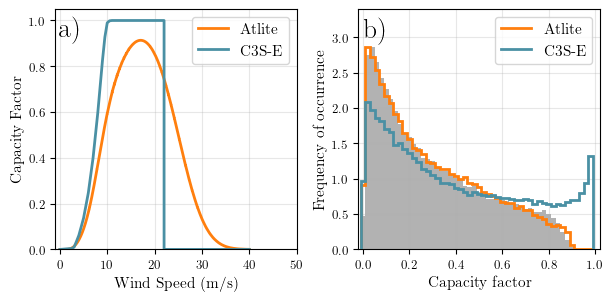

In [36]:
cm =1/2.54
fig, ax = plt.subplots(1, 2, figsize=(16*cm, 8*cm))

ax[0].plot(turbine_enercon_smooth['V'],
           turbine_enercon_smooth['POW'],
           lw=2,
           color = '#ff7f0e',
           label='Atlite',
           zorder=2)
ax[0].plot(turbine_vestas['V'],
           turbine_vestas['POW'],
           lw=2,
           color = '#4a90a4',
           label='C3S-E',
           zorder=2)

ax[0].set_xlim(-1,50)
ax[0].set_ylim(0)
ax[0].set_xlabel('Wind Speed (m/s)', color='k', fontsize=11)
ax[0].set_ylabel('Capacity Factor', color='k', fontsize=11)
ax[0].grid(alpha=0.3, zorder=0)
ax[0].legend(fontsize=11)


# ax[1].set_title('CF vs Freq')
hist_eirgrid, _, _ = ax[1].hist(cf_wind['EirGrid'], 
                                bins=bins, 
                                density=True, 
                                color='k', 
                                alpha=0.3, 
                                zorder=1)

hist_030smooth, _, _ = ax[1].hist(cf_wind['Atlite'], 
                                  bins=bins, 
                                  density=True, 
                                  color = '#ff7f0e',
                                  histtype='step', 
                                  lw=2,
                                  zorder=3)

hist_vestas, _, _ = ax[1].hist(cf_wind['C3S Gridded'], 
                               bins=bins, 
                               density=True, 
                               color = '#4a90a4',
                               histtype='step', 
                               lw=2, 
                               zorder=3)

ax[1].set_xlabel('Capacity factor', fontsize=11)
ax[1].set_ylabel('Frequency of occurrence', fontsize=11)
ax[1].grid(alpha=0.3, zorder=0)

ax[1].set_xlim(-0.02, 1.02)
ax[1].set_ylim(0, 3.4)

ax[1].margins(0.02)


total_area_030smooth = (1 - ((abs(hist_030smooth - hist_eirgrid)*(bins[1:]-bins[:-1])).sum()) / 2) * 100
total_area_vestas = (1 - ((abs(hist_vestas - hist_eirgrid)*(bins[1:]-bins[:-1])).sum()) / 2) * 100

custom_lines = [
    Line2D([0], [0], color='#ff7f0e', lw=2),
    Line2D([0], [0], color='#4a90a4', lw=2)
]

label_leg = ['Atlite',
              'C3S-E'
            ]

ax[1].legend(handles = custom_lines, labels=label_leg, fontsize=11)

ax[0].text(-0.1, 1.02, 'a)', fontsize=20, ha='left', va='top')
ax[1].text(0, 3.3, 'b)', fontsize=20, ha='left', va='top')

fig.tight_layout()
fig.savefig('verification_power_curve.pdf', bbox_inches='tight')
